# AgriGemma-3n: Fine-Tuning Gemma For On-Device Agricultural Intelligence

## Dataset Download

The **Crop Disease Domain Multimodal (CDDM)** dataset is a comprehensive agricultural AI resource containing:

- **137,000 crop disease images** paired with **1 million question-answer pairs**
- Covers **16 crop categories** and **60 disease types**
- Includes detailed Q&A conversations about disease identification, symptoms, causes, prevention, and treatment strategies
- Designed for training multimodal AI models that can provide practical farming advice

**Paper**: [A Multimodal Benchmark Dataset and Model for Crop Disease Diagnosis](https://arxiv.org/abs/2503.06973)  
**Dataset**: Available at [GitHub](https://github.com/UnicomAI/UnicomBenchmark/tree/main/CDDMBench)

This dataset is particularly well-suited for the fine-tuning of Gemma 3n as it combines visual disease identification with comprehensive agricultural knowledge that can help farmers make informed decisions in the field.

In [ ]:
!pip install -q --upgrade gdown

In [ ]:
import gdown

# Drive file ID (the long string after `/d/` in the link)
file_id = "1kfB3zkittoef4BasOhwvAb8Cb66EPXst"

# This will create dataset.zip in the working directory
gdown.download(id=file_id, output="dataset.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1kfB3zkittoef4BasOhwvAb8Cb66EPXst
From (redirected): https://drive.google.com/uc?id=1kfB3zkittoef4BasOhwvAb8Cb66EPXst&confirm=t&uuid=3a14c9e1-0273-4ca7-8b22-beaeb0e76747
To: /content/dataset.zip
100%|██████████| 2.77G/2.77G [00:16<00:00, 166MB/s]


'dataset.zip'

In [ ]:
import os, zipfile

# Make sure the destination exists
os.makedirs("dataset", exist_ok=True)

# Extract
with zipfile.ZipFile("dataset.zip", "r") as z:
    z.extractall("dataset")

print("Done! Extracted to ./dataset")


Done! Extracted to ./dataset


In [ ]:
import pathlib, itertools
first_few = itertools.islice(pathlib.Path("dataset").rglob("*"), 20)
for p in first_few:
    print(p.relative_to("dataset"))

images
VQA
images/Rice,Leaf Blight
images/Rice,Leaf Smut
images/Wheat,Healthy
images/Rice,Blast
images/Tomato,Early Blight
images/Tomato,Target Spot
images/Apple,Grey Spot
images/Tomato,Leaf Mold
images/Soybean,Healthy
images/Strawberry,Leaf Scorch
images/Potato,Late Blight
images/Corn,Leaf Spot
images/Corn,Northern Leaf Blight
images/Apple,Black Rot
images/Cherry,Powdery Mildew
images/Tomato,Bacterial Spot
images/Peach,Bacterial Spot
images/Grape,Leaf Blight


In [ ]:
!mkdir -p dataset/VQA

In [ ]:
# Raw file URL (swap github.com → raw.githubusercontent.com)
zip_url = (
    "https://raw.githubusercontent.com/"
    "UnicomAI/UnicomBenchmark/main/"
    "CDDMBench/dataset/VQA/Crop_Disease_train_qwenvl.zip"
)

# Grab it with wget (--show-progress so you see a progress bar)
!wget -q --show-progress -O Crop_Disease_train_qwenvl.zip "$zip_url"


Crop_Disease_train_ 100%[===================>]  17.32M   111MB/s    in 0.2s    


In [ ]:
import zipfile, os

os.makedirs("dataset/VQA", exist_ok=True)
with zipfile.ZipFile("Crop_Disease_train_qwenvl.zip") as z:
    z.extractall("dataset/VQA")

print("Done! Extracted to ./dataset/VQA")

Done! Extracted to ./dataset/VQA


In [ ]:
!mkdir -p dataset/VQA/test_dataset

In [ ]:
# Proper GitHub zip URL
zip_url="https://github.com/UnicomAI/UnicomBenchmark/raw/main/CDDMBench/dataset/VQA/test_dataset.zip"

# Download it
!wget -q --show-progress -O test_dataset.zip "$zip_url"

# Unzip to folder
!unzip -o test_dataset.zip -d test_dataset


test_dataset.zip    100%[===================>]  93.04K  --.-KB/s    in 0.02s   


In [ ]:
first20 = itertools.islice(pathlib.Path("dataset/VQA").rglob("*"), 20)
for p in first20:
    print(p.relative_to("dataset/VQA"))


test_dataset
Crop_Disease_train_qwenvl.json
test_dataset/disease_knowledge.json
test_dataset/disease_diagnosis.json


In [ ]:
from pathlib import Path
import json, itertools, collections, random, pprint
img_root = Path("dataset/images")        # <- change if needed

# List the first two crop/disease folders
for p in itertools.islice(img_root.iterdir(), 2):
    print("📂", p.name)


📂 Rice,Leaf Blight
📂 Rice,Leaf Smut


In [ ]:
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

all_imgs = [p for p in img_root.rglob("*") if p.suffix.lower() in img_exts]
print(f"Total images found: {len(all_imgs):,}")

# Count by crop,disease folder (folder name is "Crop,Disease")
per_class = collections.Counter(p.parent.name for p in all_imgs)
print("\nTop 10 classes by image count:")
for cls, n in per_class.most_common(10):
    crop, disease = cls.split(",", 1)
    print(f"  {crop:12} | {disease:25} : {n:5}")


Total images found: 137,007

Top 10 classes by image count:
  Tomato       | Yellow Leaf Curl Virus    :  7967
  Apple        | Leaf Rust                 :  7554
  Apple        | Healthy                   :  6269
  Tomato       | Late Blight               :  5923
  Tomato       | Bacterial Spot            :  5784
  Apple        | Brown Spot                :  5655
  Tomato       | Septoria Leaf Spot        :  5545
  Orange       | Citrus Greening           :  5507
  Tomato       | Healthy                   :  5358
  Apple        | Alternaria Blotch         :  5343


In [ ]:
def sample_images(n=24000, seed=42):
    random.seed(seed)
    return random.sample(all_imgs, n)

# Example usage:
subset = sample_images()
print("Subset example:", subset[:3])


Subset example: [PosixPath('dataset/images/Apple,Black Rot/plant_75026.jpg'), PosixPath('dataset/images/Tomato,Early Blight/plant_18950.jpg'), PosixPath('dataset/images/Tomato,Healthy/plant_23392.jpg')]


In [ ]:
vqa_root = Path("dataset/VQA")

json_files = {
    "train":  vqa_root / "Crop_Disease_train_qwenvl.json",
    "diag":   vqa_root / "test_dataset/disease_diagnosis.json",
    "know":   vqa_root / "test_dataset/disease_knowledge.json",
}

for tag, jf in json_files.items():
    with open(jf, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f"\n=== {tag.upper()} ===  {jf.name}")
    # Handle both list-style and dict-with-`data` formats
    records = data if isinstance(data, list) else data.get("data", [])
    print(f"Records: {len(records):,}")
    pprint.pprint(records[0], width=120, compact=True)



=== TRAIN ===  Crop_Disease_train_qwenvl.json
Records: 145,261
{'conversations': [{'from': 'user',
                    'value': 'Picture 1: <img>/dataset/images/Apple,Alternaria Blotch/plant_74609.jpg</img>\n'
                             'What is the content of this picture?'},
                   {'from': 'assistant', 'value': 'This image shows an apple leaf affected by Alternaria Blotch.'},
                   {'from': 'user', 'value': 'Is this crop diseased? '},
                   {'from': 'assistant', 'value': 'Yes, this apple leaf is afflicted with Alternaria Blotch.'},
                   {'from': 'user', 'value': 'What disease does this apple leaf have? '},
                   {'from': 'assistant', 'value': 'This apple leaf is affected by Alternaria Blotch.'},
                   {'from': 'user', 'value': 'Is this leaf from a pear tree? '},
                   {'from': 'assistant', 'value': 'No, this is an apple leaf.'},
                   {'from': 'user', 'value': 'Is this an apple

## Install Unsloth and Dependencies

In [ ]:
%%capture
import os, subprocess, sys, json, re, random, itertools, collections
import numpy as np
from pathlib import Path

if "COLAB_" in "".join(os.environ.keys()):
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 \
           peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" \
           "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
else:
    !pip install unsloth

# Latest Transformers + timm for Gemma-3N
!pip install --no-deps --upgrade transformers timm


## Load and Configure Model
#### Load Gemma-3n-E4B-it base model

In [ ]:
from unsloth import FastVisionModel, get_chat_template
import torch, gc

model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E4B-it",   #  instruct-tuned
    dtype          = None,    # auto
    max_seq_length = 2048,
    load_in_4bit   = True,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.54.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Configure LoRA fine-tuning

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r              = 32,          #
    lora_alpha     = 32,
    lora_dropout   = 0.05,
    bias           = "none",
    random_state   = 3407,
    target_modules = "all-linear",
)


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model.language_model` require gradients


### Prepare Training Data

In [ ]:
# ---------- paths ----------
IMG_ROOT = Path("dataset/images")                     # your image tree
TRAIN_JSON = Path("dataset/VQA/Crop_Disease_train_qwenvl.json")

# ---------- 3.1 collect images & stratified 8 k sample ----------
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
all_imgs  = [p for p in IMG_ROOT.rglob("*") if p.suffix.lower() in img_exts]

# bucket by "Crop,Disease" folder
buckets = collections.defaultdict(list)
for p in all_imgs:
    buckets[p.parent.name].append(p)

# ── take ≤133 per disease so 60 diseases → ≈8 k
random.seed(42)
target_per_bucket = 150
sampled_imgs = []
for lst in buckets.values():
    k = min(len(lst), target_per_bucket)
    sampled_imgs.extend(random.sample(lst, k))

sampled_set = set(sampled_imgs)     # for O(1) lookup

print(f"Sampling → {len(sampled_set):,} images")


Sampling → 8,672 images


### Extract Q&A pairs from JSON

In [ ]:
# ---------- 3.2  •  parse JSON → (img, question, answer) tuples ----------

import json, re
from pathlib import Path
from PIL import Image

# 📝 1) Build a *string* set of the 7 720 sampled image paths
#      • all lowercase / forward-slash / no leading "/" → "dataset/images/…"
sampled_set = {p.as_posix().lstrip("/") for p in sampled_imgs}

def extract_pairs(record):
    """
    Yield tuples:
        (Path image_path, str question, str answer)
    Only keep images that are in our  subset.
    """
    conv = record["conversations"]
    for i in range(0, len(conv) - 1, 2):
        user, assistant = conv[i], conv[i + 1]
        if user["from"] != "user" or assistant["from"] != "assistant":
            continue

        # ---- pull the image tag ----
        m = re.search(r"<img>(.*?)</img>", user["value"])
        if not m:
            continue
        raw_path = m.group(1).lstrip("/")                # drop leading "/"
        if raw_path not in sampled_set:                  # keep only subset
            continue

        # ---- clean up Q & A ----
        question = re.sub(r"<img>.*?</img>", "", user["value"]).strip()
        answer   = assistant["value"].strip()

        yield Path(raw_path), question, answer


# ---------- run the extraction ----------
records = []
with TRAIN_JSON.open() as f:
    data = json.load(f)

for rec in data:
    records.extend(extract_pairs(rec))

print(f"Pairs kept: {len(records):,}")   #  should now be > 0,


Pairs kept: 9,970


### Convert to Gemma-3n chat format

In [ ]:
# ---------- 3.3 convert to UnsLoTH "messages" format ----------
def to_conversation(img_path, q, a):
    img = Image.open(img_path).convert("RGB")
    return {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text",  "text": q},
                    {"type": "image", "image": img},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": a}],
            },
        ]
    }

converted_dataset = [to_conversation(*t) for t in records]
print("✅ dataset ready:", len(converted_dataset))


✅ dataset ready: 9970


#### Apply chat template

In [ ]:
processor = get_chat_template(processor, "gemma-3n")   # in-place patch

### Configure Weights & Biases

In [ ]:
# 📌 1.  W&B login & project/run setup  ────────────────
import os, wandb
if wandb.api.api_key is None:
    wandb.login()                           # prompts once if needed

PROJECT_NAME = "Agri-gemma3n-finetune"
RUN_NAME     = "agri-gemma-3n-E4B-it"

os.environ["WANDB_PROJECT"] = PROJECT_NAME
wandb.init(project=PROJECT_NAME, name=RUN_NAME, reinit=True)

# 📌 2.  Trainer – 1-epoch run on 25 k examples ─────────
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model            = model,
    train_dataset    = converted_dataset,     # ~25 k items
    processing_class = processor.tokenizer,
    data_collator    = UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        # ── core hyper-params ──────────────────────────
        per_device_train_batch_size = 2,      # fits comfortably on an A100
        gradient_accumulation_steps = 4,      # ⇒ effective batch ≈ 8
        num_train_epochs            = 1,      # ← full pass over 25 k
        learning_rate               = 2e-4,
        warmup_ratio                = 0.03,
        max_grad_norm               = 0.3,
        logging_steps               = 20,
        save_strategy               = "epoch",
        optim                       = "adamw_torch_fused",
        weight_decay                = 0.01,
        lr_scheduler_type           = "cosine",
        seed                        = 3407,
        max_length                  = 2048,

        # ── W&B hook ──────────────────────────────────
        report_to                   = "wandb",
        run_name                    = RUN_NAME,

        # ── misc / vision flags ───────────────────────
        output_dir                  = "outputs_AgriGemma",
        remove_unused_columns       = False,
        dataset_text_field          = "",
        dataset_kwargs              = {"skip_prepare_dataset": True},
    ),
)


wandb: Currently logged in as: alfaxadeyembe (alfaxad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Unsloth: Model does not have a default image size - using 512


### Execute training

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,970 | Num Epochs = 1 | Total steps = 1,247
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 76,840,960 of 7,926,819,152 (0.97% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
20,3.384400
40,1.460300
60,1.100000
80,1.280600
100,0.924800
120,0.932500
140,0.842700
160,0.867700
180,0.761000
200,0.625400


## Test the Fine-tuned model

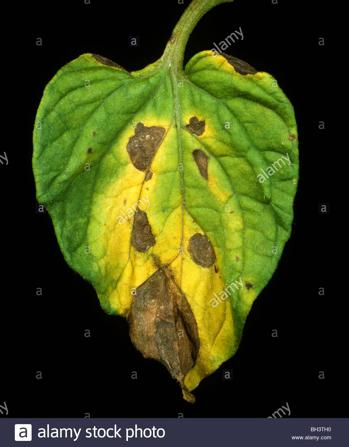

In [ ]:
from PIL import Image
Image.open("/content/dataset/images/Tomato,Early Blight/plant_17947.jpg").convert("RGB")

In [ ]:
FastVisionModel.for_inference(model)  # Enable for inference!


image = Image.open("/content/dataset/images/Tomato,Early Blight/plant_17947.jpg").convert("RGB")



instruction = "Identify the crop and describe the disease symptoms shown in this image."

# 3️⃣ Build a Gemma-3N multimodal chat message
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},                     # placeholder only
            {"type": "text", "text": instruction},
        ],
    }
]

# 4️⃣ Convert to model input
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# 5️⃣ Generate
from transformers import TextStreamer
streamer = TextStreamer(processor, skip_prompt=True)

_ = model.generate(
    **inputs,
    max_new_tokens = 128,
    use_cache      = True,
    temperature    = 1.0,
    top_p          = 0.95,
    top_k          = 64,
    streamer       = streamer,
)


The crop is tomato. The disease symptoms are brown and yellow necrotic lesions with black dots, characteristic of Septoria Leaf Spot.<end_of_turn>


## Save The LoRA Updates, Save The Model In Various Formats And Push it To HuggingFace

In [ ]:
model.save_pretrained("agri-gemma-3n-e4b-lora")  # Local saving
processor.save_pretrained("agri-gemma-3n-e4b-lora")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

['agri-gemma-3n-e4b-lora/processor_config.json']

In [ ]:
if True: # Change to True to save finetune!
    model.save_pretrained_merged("AgriGemma-3n-E4B-it", processor)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [00:16<00:48, 16.29s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [00:46<00:49, 24.56s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [01:21<00:29, 29.14s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [01:44<00:00, 26.03s/it]


In [ ]:
if True: # Change to True to upload finetune
    model.push_to_hub_merged(
        "Account/AgriGemma-3n-E4B-it", processor,
        token = "hf"
    )

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  .../AgriGemma-3n-E4B-it/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...AgriGemma-3n-E4B-it/tokenizer.model: 100%|##########| 4.70MB / 4.70MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...it/model-00001-of-00004.safetensors:   1%|1         | 41.8MB / 3.08GB            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [00:46<02:18, 46.01s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...it/model-00002-of-00004.safetensors:   1%|          | 41.9MB / 4.97GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [02:04<02:09, 64.91s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...it/model-00003-of-00004.safetensors:   0%|          | 2.41MB / 4.99GB            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [03:42<01:20, 80.19s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...it/model-00004-of-00004.safetensors:   0%|          | 36.1kB / 2.66GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [04:45<00:00, 71.28s/it]


In [ ]:
if True: # Change to True to save to GGUF
    model.save_pretrained_gguf(
        "AgriGemma-3n-E4B-it",
        quantization_type = "Q8_0", # For now only Q8_0, BF16, F16 supported
    )

Unsloth: Updating system package directories
Unsloth: Install GGUF and other packages
Unsloth GGUF:hf-to-gguf:Loading model: AgriGemma-3n-E4B-it
Unsloth GGUF:hf-to-gguf:Model architecture: Gemma3nForConditionalGeneration
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00004.safetensors'
Unsloth GGUF:hf-to-gguf:altup_proj.weight,                 torch.bfloat16 --> Q8_0, shape = {2048, 2048, 3}
Unsloth GGUF:hf-to-gguf:altup_unembd_proj.weight,          torch.bfloat16 --> Q8_0, shape = {2048, 2048, 3}
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2048, 262144}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00004.safetensors'
Unsloth GGUF:hf-to-gguf:per_layer_token_embd.weight,       torch.bfloat16 -->

Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to AgriGemma-3n-E4B-it.Q8_0.gguf with size = 7.3G
Unsloth: Successfully saved GGUF to:
AgriGemma-3n-E4B-it.Q8_0.gguf


In [ ]:
if True: # Change to True to upload GGUF
    model.push_to_hub_gguf(
        "AgriGemma-3n-E4B-it",
        quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
        repo_id = "Account/AgriGemma-3n-E4B-it-gguf",
        token = "hf",
    )

Unsloth GGUF:hf-to-gguf:Loading model: AgriGemma-3n-E4B-it
Unsloth GGUF:hf-to-gguf:Model architecture: Gemma3nForConditionalGeneration
Unsloth GGUF:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
Unsloth GGUF:hf-to-gguf:Exporting model...
Unsloth GGUF:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00001-of-00004.safetensors'
Unsloth GGUF:hf-to-gguf:altup_proj.weight,                 torch.bfloat16 --> Q8_0, shape = {2048, 2048, 3}
Unsloth GGUF:hf-to-gguf:altup_unembd_proj.weight,          torch.bfloat16 --> Q8_0, shape = {2048, 2048, 3}
Unsloth GGUF:hf-to-gguf:token_embd.weight,                 torch.bfloat16 --> Q8_0, shape = {2048, 262144}
Unsloth GGUF:hf-to-gguf:gguf: loading model part 'model-00002-of-00004.safetensors'
Unsloth GGUF:hf-to-gguf:per_layer_token_embd.weight,       torch.bfloat16 --> Q8_0, shape = {8960, 262144}
Unsloth GGUF:hf-to-gguf:output_norm.weight,             

Unsloth: GGUF conversion:   0%|          | 0/100 [00:00<?, ?it/s]

Unsloth GGUF:hf-to-gguf:Model successfully exported to ./
Unsloth: Converted to AgriGemma-3n-E4B-it.Q8_0.gguf with size = 7.3G
Unsloth: Successfully saved GGUF to:
AgriGemma-3n-E4B-it.Q8_0.gguf


No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj="AgriGemma-3n-E4B-it.Q8_0.gguf",
    path_in_repo="AgriGemma-3n-E4B-it.Q8_0.gguf",
    repo_id="Nadhari/AgriGemma-3n-E4B-it-gguf",
    token="hf_"
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  AgriGemma-3n-E4B-it.Q8_0.gguf         :   0%|          | 16.8MB / 7.30GB            

CommitInfo(commit_url='https://huggingface.co/Nadhari/AgriGemma-3n-E4B-it-gguf/commit/0b1844cf28bf1949b0963a3d64433fcb38fe1882', commit_message='Upload AgriGemma-3n-E4B-it.Q8_0.gguf with huggingface_hub', commit_description='', oid='0b1844cf28bf1949b0963a3d64433fcb38fe1882', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Nadhari/AgriGemma-3n-E4B-it-gguf', endpoint='https://huggingface.co', repo_type='model', repo_id='Nadhari/AgriGemma-3n-E4B-it-gguf'), pr_revision=None, pr_num=None)